In [6]:
import os
os.environ["DISPLAY"] = ":1"
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import gymnasium as gym

from stable_baselines3 import A2C

import vista
from vista.utils import transform
from vista.entities.agents.Dynamics import tireangle2curvature
import time
import torch
import numpy as np

device = ("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.4     |
|    ep_rew_mean        | 22.4     |
| time/                 |          |
|    fps                | 366      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | -0.264   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -1.52    |
|    value_loss         | 30.3     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 24.4     |
|    ep_rew_mean        | 24.4     |
| time/                 |          |
|    fps                | 470      |
|    iterations         | 200      |
|    time_elapsed

In [3]:
vec_env = model.get_env()
obs = vec_env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    vec_env.render("human")
    # VecEnv resets automatically
    # if done:
    #   obs = vec_env.reset()

2023-09-26 16:39:27,026::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-09-26 16:39:30,544::WARNING::[vista.entities.sensors.Camera.reset] No flow data


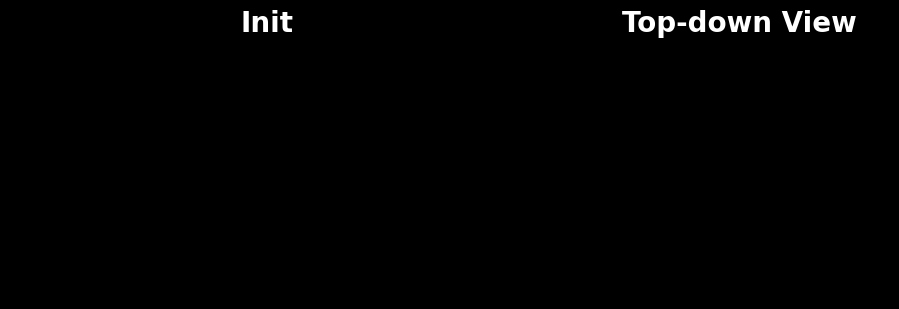

In [2]:
world = vista.World(["../vista_nautilus/vista_traces/20210726-131322_lexus_devens_center"], 
                    trace_config={'road_width': 4})
car = world.spawn_agent(
    config={
        'length': 5.,
        'width': 2.,
        'wheel_base': 2.78,
        'steering_ratio': 14.7,
        'lookahead_road': True
    })

camera_config = {'name': 'camera_front',
                 'rig_path': './RIG.xml',
                 'optical_flow_root': '../data_prep/Super-SloMo/slowmo',
                 'size': (355, 413)}
camera = car.spawn_camera(camera_config)
display = vista.Display(world)

world.reset()
display.reset()

In [4]:
def follow_human_trajectory(agent):
    action = np.array([
        agent.trace.f_curvature(agent.timestamp),
        agent.trace.f_speed(agent.timestamp)
    ])
    return action

In [8]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
i = 0
while not car.done:
    action = follow_human_trajectory(car)
    car.step_dynamics(action)
    car.step_sensors()

    # vis_img = display.render()
    i1, j1, i2, j2 = camera.camera_param.get_roi()
    full_obs = car.observations[camera.name]
    obs = full_obs[i1:i2, j1:j2]
    plt.imshow(obs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    i += 1

KeyboardInterrupt: 